# Eindopdracht: Zeef van Eratosthenes

Voor deze opdracht moest een conceptueel eenvoudig probleem opgelost worden. Echter is dit probleem computationeel lastig, en erg belangrijk voor cryptografie en security.  
Het gaat om het vinden van alle priemgetallen tot een bepaalde (grote) limietwaarde. Om dit probleem op te lossen gaan we een "hybride" parallelle versie maken van een klassiek algoritme, genaamd [Eratosthenes Zeef](https://nl.wikipedia.org/wiki/Zeef_van_Eratosthenes).

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time

## Sequentiële Zeef

Allereerst wordt de sequentiële zeef gebouwd om zometeen mee te kunnen vergelijken.

In [3]:
def find_primes_sieve(N):
    """Finds all primes between 0 and N"""
    
    sieve = [True for i in range(N + 1)]
    p = 2
    
    while (p * p <= N):
        
        # check if current number is prime
        if sieve[p]:
            
            # Update all multiples of p
            for i in range(p * 2, N + 1, p):
                sieve[i] = False
        p += 1
    
    # set 0 and 1 to false
    sieve[0] = False
    sieve[1] = False
    
    # iterate over the whole list and return all the primes
    primes = list()
    for x in range(N + 1):
        if sieve[x]:
            primes.append(x)
    
    return primes 

Hierna wordt de functie getest op geldigheid.

In [4]:
# The list with actual primes under 100
primes_under_100 = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]

# The list with primes the function gave back
sieve_answer = find_primes_sieve(100)

# check if the two lists are identical
print(primes_under_100 == sieve_answer)

True


Ook wordt de functie getimed, waarbij de priemgetallen tot en met 100.000.000 gevonden worden met behulp van de sequentiële aanpak.

In [5]:
start_time = time.time()

# running the function with 100 million items
n = 100000000
find_primes_sieve(n)

end_time = time.time()
print("The algorithm took {0} seconds over {1} items".format(round(end_time - start_time, 3), n))

The algorithm took 27.999 seconds over 100000000 items


## Parallelle Zeef

### Ontwerp
Het programma wordt uiteindelijk gedraaid door het commando:  
$\textbf{mpirun -n 4 Parallel-Sieve.py 1000}$  
te draaien in de command line.  
  
Tijdens dit commando worden er twee argumenten meegegeven die uiteindelijk voor het draaien van het programma cruciaal zijn. Allereerst wordt meegegeven met hoeveel processen het programma mag draaien en ten tweede wordt meegegeven tot hoever het programma moet gaan zoeken naar priemgetallen.  
  
In het bovenstaande voorbeeld zal het programma dus met 4 processen naar alle priemgetallen tot de 1000 zoeken. De volgende stappen worden dan genomen door het programma.  
  
Het programma werkt volgens het master-worker model, dit betekent dat er één proces is die de andere processen in gang zet. Allereerst worden de bereiken bepaald van de arrays die uiteindelijk ieder proces zal doorlopen. Dit zal betekenen dat met duizend elementen in totaal de master alle priemgetallen checkt van 0 tot 250, proces 1 251 tot 500, enzovoorts.  

De master berekent deze ranges uit en informeert de processen welke begin en eind range ze hebben, zodat de processen alvast voor zichzelf deze informatie kunnen opslaan en de lokale true/false array kunnen aanmaken.  

Hierna zal de master in zijn eigen array gaan zoeken naar het eerstvolgende priemgetal zolang $p^2 <= N$. Wanneer de master een priemgetal gevonden heeft geeft hij dit door aan alle processen waarna zowel de master als de processen alle niet-priemgetallen in hun lokale arrays omzetten naar False.  

Wanneer de master tot zijn eind voorwaarde gekomen is geeft hij dit door aan alle processen zodat de master en alle processen kunnen berekenen welke priemgetallen ze nou precies in hun array overhouden. Deze array van priemgetallen sturen ze dan ook uiteindelijk terug naar de master zodat hij deze dan ook uiteindelijk kan samenvoegen om zo één lijst met alle priemgetallen terug te geven.

### Overhead
Zoals al eerder vermeld wordt voor de parallelle implementatie gebruik gemaakt van de master-worker model. De master zoekt naar het volgende priemgetal en wanneer hij die gevonden heeft stuurt hij deze door naar alle werkers, waarna alle werkers en de master zelf de meervouden hiervan uit hun lijst schrappen.  
Hiervoor is er wel een significante overhead nodig, omdat ieder priemgetal die de master tegenkomt doorgestuurt wordt naar de werkers. Wanneer de werkers eenmaal klaar zijn met hun berekeningen zullen ze weer wachten tot de master een bericht stuurt. De werkers gaan dus constant van 'berekeningen uitvoeren' naar 'wachten op een bericht vanuit de master'. Alleen op het laatste zullen ze wat terug sturen en dat is dan uiteindelijk de lijst met alle priemgetallen die ze zelf berekend hebben.

### Resulaten
De Zeef is uiteindelijk getest met 100 miljoen getallen. Uiteindelijk is ervoor gekozen om van 1 tot 16 processen te testen. Hieronder worden de resultaten ervan in een grafiek gezet.

In [6]:
df_data = pd.read_csv('Sieve_speedtest.csv')
df_data

,Method,Number of Processes,Time,elements
0,Sequential,1,27.56,100000000
1,Parallel (MPI),1,92.76,100000000
2,Parallel (MPI),2,49.42,100000000
3,Parallel (MPI),4,36.93,100000000
4,Parallel (MPI),8,40.90,100000000
5,Parallel (MPI),16,54.58,100000000


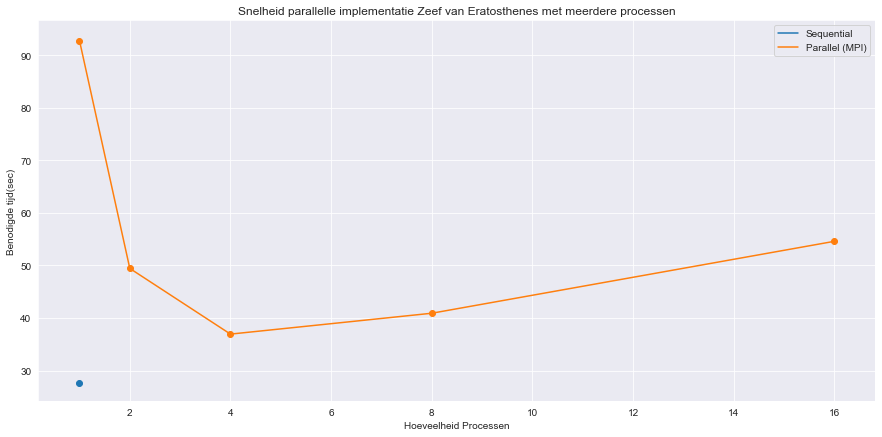

In [8]:
sns.set_style("darkgrid")
plt.figure(figsize=(15, 7))

# get all the methods
methods = df_data['Method'].unique()

# plot the time for every amount of processes
for method in df_data['Method'].unique():
    x = df_data[df_data['Method'] == method]['Number of Processes']
    y = df_data[df_data['Method'] == method]['Time']
    
    plt.plot(x, y, label=method)
    plt.scatter(x, y)
    

# add title and x, y labels
plt.title("Snelheid parallelle implementatie Zeef van Eratosthenes met meerdere processen")
plt.xlabel("Hoeveelheid Processen")
plt.ylabel("Benodigde tijd(sec)")

plt.legend()
plt.show()

### Analyse Resultaten

Zoals in de grafiek te zien is neemt de benodigde snelheid met de parallelle methode aan het begin af om daarna weer langzaam toe te nemen. Dit valt voornamelijk te wijten aan het feit dat de computer waarop het gedraaid wordt 3 cores tot zijn beschikking heeft.  
  
Verder valt te zien dat de sequentiële manier sneller is dan alle parallelle manieren. Dit is waarschijnlijk te wijten aan het feit dat de code redelijk wat overhead heeft en dus langer erover zal doen dan de sequentiële versie met 100 miljoen elementen.

## Reflectie opdracht

Het is me uiteindelijk redelijk gelukt om een werkende parallelle versie van de zeef te programmeren.  

Echter wanneer het programma aangeroepen wordt met een lage N en een grote hoeveelheid processen geeft hij een error. Dit komt omdat tijdens het verdelen van de ranges, het programma ervan uit gaat dat de master array tenminste $\sqrt{N}$ elementen heeft en met bepaalde begin settings heeft de array dit niet. Het is me (tot op heden) nog niet gelukt om tijdens het verdelen van de workload hiermee rekening te houden. Echter moet ik hierbij wel zeggen dat de limietwaarde dusdanig laag is op deze momenten dat de gebruiker erover na zou kunnen denken om de priemgetallen via de sequentiële manier te berekenen.  

Ik vond het voornamelijk lastig bij deze opdracht om het algoritme parallel te krijgen. Ik heb dan ook uiteindelijk het programma twee keer bijna geheel moeten herschrijven omdat ik een richting inging die uiteindelijk op niets bleek uit te komen. Ik vond het ook lastig (zoals ik al eerder vermeld had) om de workload 'eerlijk' te verdelen ten opzichte van de voorwaarde van de zeef en de hoeveelheid processen.

Oorspronkelijk wilde ik het programma met een hogere limietwaarde dan 100 miljoen draaien en met meerdere processen, echter omdat ik dit op mijn eigen laptop draaide is me dit niet gelukt. Allereerst liep mijn computer tegen een 'memory-error' aan wanneer ik de sequentiële versie draaide met 1 miljard. Ten tweede liet ik mijn VM crashen wanneer ik de parallele versie draaide met meer dan 16 processen.  
  
Uiteindelijk heb ik een programma opgeleverd die op een parallelle manier gebruik makend van MPI de priemgetallen tot een bepaalde limietwaarde kan berekenen. Ik ben hier dan ook best wel trots op.